In [1]:
import sys
sys.path.insert(0, '/Users/maithilypande/Downloads/dataset_diabetes/diabetic_data.csv')
import pandas as pd
import numpy as np
import data_loader
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)


## Data Splitting

In [2]:
ret = data_loader.load_dataset('/Users/maithilypande/Downloads/dataset_diabetes/diabetic_data.csv', valid_rate=0.15)
train_features_list = ret[0]
train_label_list = ret[1]
valid_features_list = ret[2]
valid_label_list = ret[3]
test_features_list = ret[4]
test_label_list = ret[5]

In [3]:
def formDataFrame(list):
    x = pd.DataFrame(list)    
    x.columns = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']   
    return x

In [4]:
df_train = formDataFrame(train_features_list)

## Data Visualization

In [ ]:
diabetes = formDataFrame(train_features_list)

In [ ]:
diabetes.head()  

In [ ]:
print("dimension of diabetes data: {}".format(diabetes.shape))

In [ ]:
df.info()

In [ ]:
diabetes.groupby('citoglipton').size()

In [ ]:
diabetes.groupby('examide').size()

In [ ]:
for c in list(df.columns):   
    n = df[c].unique()
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

In [ ]:
scatter_matrix(df_data)
plt.show()

import seaborn as sns
sns.set(style="ticks")


sns.pairplot(df_data, hue = "OUTPUT_LABEL")

In [ ]:
import seaborn as sns
sns.countplot(df_data['OUTPUT_LABEL'],label="Count").set_title('Training Set Output feature distribution')

In [ ]:
features=['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
               'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
               'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
               'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
               'metformin-rosiglitazone', 'metformin-pioglitazone','insulin']
for i in range(23):
    diabetes.groupby(features[i]).size().plot(kind='bar')
    plt.show()

## Data Preprocessing

In [5]:
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses','diag1']
cols_cat = ['race', 'gender', 'max_glu_serum', 'A1Cresult','change', 'diabetesMed']
cols_cat_num = ['admission_type_id', 'discharge_disposition_id']

In [6]:
def preprocess1(df):
    drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)
    drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
    new_Idx = list(set(df.index) - set(drop_Idx))
    df = df.iloc[new_Idx]
    df = df.replace('?',np.nan)
    df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]
    df.drop(['payer_code','medical_specialty','weight','diag_2','diag_3'], axis=1) 
    df['race'] = df['race'].fillna('UNK')
    df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
    df[cols_cat_num] = df[cols_cat_num].astype('str')
    return df

In [7]:
def preprocess2(label_list, df):
    df_cat = pd.get_dummies(df[cols_cat + cols_cat_num ],drop_first = False)
    df = pd.concat([df,df_cat], axis = 1)
    cols_all_cat = list(df_cat.columns)
    age_id = {'[0-10)':0, '[10-20)':10, '[20-30)':20, '[30-40)':30, '[40-50)':40, '[50-60)':50,'[60-70)':60, '[70-80)':70, '[80-90)':80, 
              '[90-100)':90}
    df['age_group'] = df.age.replace(age_id)
    cols_extra = ['age_group']
    df['OUTPUT_LABEL'] = pd.Series(train_label_list)   
    col2use = cols_num + cols_all_cat + cols_extra
    df_data = df[col2use+ ['OUTPUT_LABEL']]
    return df_data, col2use

In [8]:
def processCatCols(df):
    for column in cols_cat:
        category = df_train[column].unique()
        df[column] = df[column].astype("category", categories = category)
    for col in cols_cat_num:
        category = df_train[col].unique()
        df[col] = df[col].astype("category", categories = category)  
    return df

In [9]:
def Diag(df):
    df['diag1'] = df['diag_1']   
    df.loc[df['diag_1'].str.contains('V'), ['diag1']] = 0
    df.loc[df['diag_1'].str.contains('E'), ['diag1']] = 0
    df['diag1'] = df['diag1'].replace('?', -1)
    df['diag1'] = df['diag1'].astype(float)
    return df

### Train Preprocess

In [10]:
df_train.shape

(77854, 49)

In [11]:
df_train = formDataFrame(train_features_list)
df_train = Diag(df_train)
df_train = preprocess1(df_train)
df_data_train, cols2use = preprocess2(train_label_list, df_train)

In [12]:
y_train = df_data_train['OUTPUT_LABEL'].values
X_train = df_data_train[cols2use].values
print(X_train.shape)
print(y_train.shape)

(56747, 59)
(56747,)


### Validation Preprocess

In [13]:
df_valid = formDataFrame(valid_features_list)
print(df_valid.shape)
df_valid = Diag(df_valid)
df_valid = preprocess1(df_valid)
print(df_valid.shape)
df_valid = processCatCols(df_valid)
print(df_valid.shape)
df_data_valid, col2use = preprocess2(valid_label_list, df_valid)
print(df_data_valid.shape)

(13737, 49)
(12478, 50)
(12478, 50)
(12478, 60)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [14]:
y_valid = df_data_valid['OUTPUT_LABEL'].values
X_valid = df_data_valid[col2use].values

print(X_valid.shape)
print(y_valid.shape)

(12478, 59)
(12478,)


### Test Preprocess

In [15]:
df_test = formDataFrame(test_features_list)
df_test = Diag(df_test)
df_test = preprocess1(df_test)

df_test = processCatCols(df_test)
df_data_test, col2use = preprocess2(test_label_list, df_test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


In [16]:
y_test = df_data_test['OUTPUT_LABEL'].values
X_test = df_data_test[col2use].values

print(X_test.shape)
print(y_test.shape)

(9370, 59)
(9370,)


## Models

### Logistic Regression ###

In [17]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=50, multi_class='ovr',solver='newton-cg').fit(X_train, y_train)
print("Training set score:",logreg.score(X_train, y_train))
print("Valid set score:",logreg.score(X_valid, y_valid))
print("Test set score:",logreg.score(X_test, y_test))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Training set score: 0.6462368054698927
Valid set score: 0.520676390447187
Test set score: 0.5277481323372465


/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [18]:
from sklearn.feature_selection import RFECV
logreg_model = logreg
rfecv = RFECV(estimator=logreg_model, step=1, scoring='accuracy')
rfecv.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. I

RFECV(cv='warn',
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=None,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

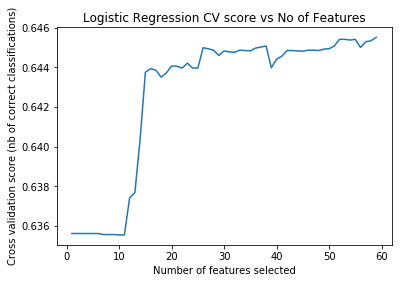

In [19]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

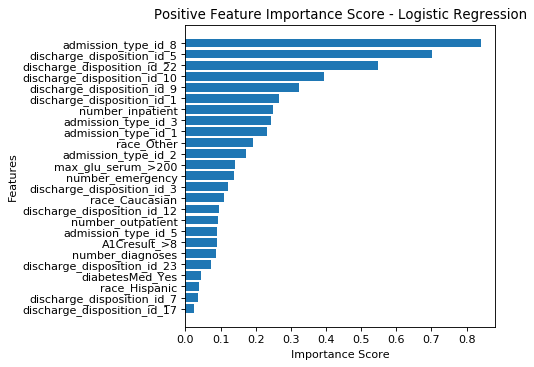

In [42]:
feature_importances = pd.DataFrame(logreg.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
num = 25
ylocs = np.arange(num)
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(5, 5), dpi = 80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

### MLP

In [23]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver = 'sgd', alpha=0.01,batch_size=200,
                    hidden_layer_sizes=(256,128,3), verbose = True, activation = 'relu')
clf.fit(X_train, y_train)
loss = []
loss.append(clf.loss_)
train_pred = clf.predict(X_train)
valid_pred = clf.predict(X_valid)
test_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy1 = accuracy_score(y_train, train_pred)
accuracy2 = accuracy_score(y_valid, valid_pred)
accuracy3 = accuracy_score(y_test, test_pred)
print("train = ", accuracy1, "valid = ", accuracy2, "test = ", accuracy3)

Iteration 1, loss = 1.23664868
Iteration 2, loss = 0.92463795
Iteration 3, loss = 0.87627706
Iteration 4, loss = 0.86381680
Iteration 5, loss = 0.85917437
Iteration 6, loss = 0.85711888
Iteration 7, loss = 0.85615039
Iteration 8, loss = 0.85567506
Iteration 9, loss = 0.85543173
Iteration 10, loss = 0.85530344
Iteration 11, loss = 0.85524586
Iteration 12, loss = 0.85519724
Iteration 13, loss = 0.85518175
Iteration 14, loss = 0.85516513
Iteration 15, loss = 0.85516538
Iteration 16, loss = 0.85515672
Iteration 17, loss = 0.85515108
Iteration 18, loss = 0.85514893
Iteration 19, loss = 0.85514976
Iteration 20, loss = 0.85514543
Iteration 21, loss = 0.85514512
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train =  0.6356283151532239 valid =  0.5350216380830262 test =  0.5382070437566703


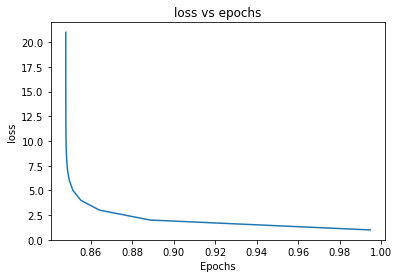

In [43]:
#Collect loss values in an array and plot the graph
loss_values = [0.99457122,0.88860118,0.86423100,0.85521767,0.85141342,0.84967812,0.84884067,0.84842612,0.84821510,0.84810091,0.84804736,0.84801786,0.84800166,0.84799057,0.84798473,0.84798377, 0.84798150,0.84798104,0.84798333,0.84798042,0.84798060 ]
import matplotlib.pyplot as plt
plt.plot(loss_values,range(1,22))
plt.title('loss vs epochs')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

### SGD

In [47]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.6,random_state = 42)
sgdc.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.6, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
train_pred = sgdc.predict(X_train)
valid_pred = sgdc.predict(X_valid)
test_pred = sgdc.predict(X_test)

In [49]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(train_pred,y_train))
print("Accuracy:",metrics.accuracy_score(valid_pred,y_valid))
print("Accuracy:",metrics.accuracy_score(test_pred,y_test))

Accuracy: 0.6386416903096199
Accuracy: 0.5274082384997596
Accuracy: 0.532017075773746


### Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
train_pred = tree.predict(X_train)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(train_pred,y_train))

Accuracy: 1.0


In [70]:
tree = DecisionTreeClassifier(max_depth = 3, random_state=0)
tree.fit(X_train, y_train)
train_pred = tree.predict(X_train)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(train_pred,y_train))

Accuracy: 0.6441221562373342


In [71]:
tree = DecisionTreeClassifier(max_depth = 3, random_state=0)
tree.fit(X_train, y_train)
valid_pred = tree.predict(X_valid)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(valid_pred,y_valid))

Accuracy: 0.5064914249078378


In [72]:
tree = DecisionTreeClassifier(max_depth = 3, random_state=0)
tree.fit(X_train, y_train)
test_pred = tree.predict(X_test)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test_pred,y_test))

Accuracy: 0.5082177161152615


In [54]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [73]:
print("Confusion Metrix Valid:\n",metrics.confusion_matrix(train_pred, y_train))
print("Confusion Metrix Valid:\n",metrics.confusion_matrix(valid_pred, y_valid))

Confusion Metrix Valid:
 [[ 1975  1493   824]
 [14140 34577  3738]
 [    0     0     0]]
Confusion Metrix Valid:
 [[ 544  900  157]
 [3842 5776 1259]
 [   0    0    0]]


### Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(train_pred,y_train))

Accuracy: 1.0


In [60]:
print(rf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [86]:
rf = RandomForestClassifier(max_depth=3, n_estimators=50, random_state=0)
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(train_pred,y_train))

Accuracy: 0.6356283151532239


In [62]:
print(rf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 250, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [87]:
rf = RandomForestClassifier(max_depth=3,n_estimators=50,random_state=0)
rf.fit(X_train, y_train)
valid_pred = rf.predict(X_valid)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(valid_pred,y_valid))

Accuracy: 0.5350216380830262


In [88]:
rf = RandomForestClassifier(max_depth=3,n_estimators=50, random_state=0)
rf.fit(X_train, y_train)
test_pred = rf.predict(X_test)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test_pred,y_test))

Accuracy: 0.5382070437566703


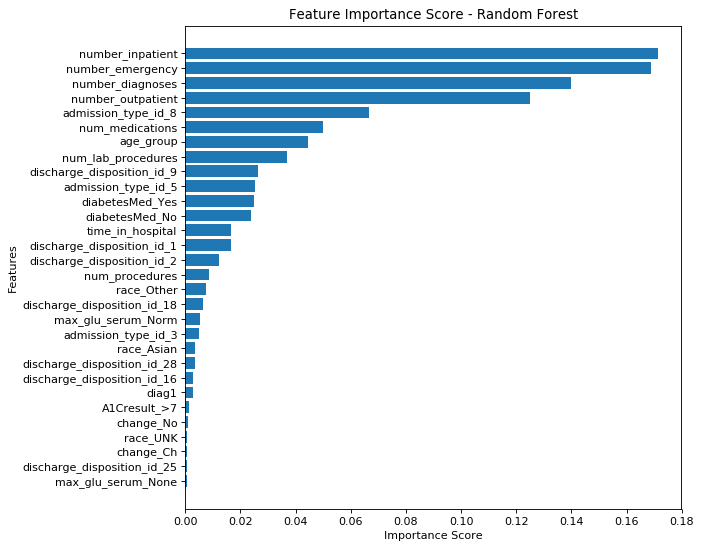

In [90]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance', ascending=False)
num = 30
ylocs = np.arange(num)
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

## Neural Networks ##

In [93]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.layers import Dropout 
from keras.layers.normalization import BatchNormalization 
nn = Sequential()
nn.add(Dense(256, activation='relu', input_shape=(59,)))
nn.add(BatchNormalization())
nn.add(Dense(128, activation='relu'))
nn.add(BatchNormalization())
nn.add(Dropout(0.3))
nn.add(Dense(3, activation='softmax'))
nn.compile(loss='sparse_categorical_crossentropy', optimizer = SGD(lr = 0.00125), metrics=['accuracy'])
history = nn.fit(X_train, y_train, batch_size = 32, epochs = 20, verbose = 1, validation_data= (X_valid, y_valid))
loss_train, accuracy_train  = nn.evaluate(X_train, y_train, verbose=False)
loss, accuracy  = nn.evaluate(X_valid, y_valid, verbose=False)
loss_test, accuracy_test  = nn.evaluate(X_test, y_test, verbose=False)

Train on 56747 samples, validate on 12478 samples
Epoch 1/20
56747/56747 [==============================] - 13s 234us/step - loss: 1.1106 - acc: 0.5042 - val_loss: 0.9861 - val_acc: 0.5225
Epoch 2/20
56747/56747 [==============================] - 10s 185us/step - loss: 0.9629 - acc: 0.5880 - val_loss: 0.9931 - val_acc: 0.4748
Epoch 3/20
56747/56747 [==============================] - 11s 196us/step - loss: 0.9205 - acc: 0.6051 - val_loss: 0.9972 - val_acc: 0.5347
Epoch 4/20
56747/56747 [==============================] - 11s 198us/step - loss: 0.8907 - acc: 0.6158 - val_loss: 1.0705 - val_acc: 0.5350
Epoch 5/20
56747/56747 [==============================] - 10s 184us/step - loss: 0.8772 - acc: 0.6218 - val_loss: 1.0106 - val_acc: 0.5344
Epoch 6/20
56747/56747 [==============================] - 10s 182us/step - loss: 0.8695 - acc: 0.6278 - val_loss: 0.9934 - val_acc: 0.5342
Epoch 7/20
56747/56747 [==============================] - 10s 181us/step - loss: 0.8604 - acc: 0.6294 - val_loss: 1.

In [94]:
print('Train accuracy: ', accuracy_train)
print('Valid accuracy: ',accuracy)
print('Test accuracy: ',accuracy_test)

Train accuracy:  0.6351701411570377
Valid accuracy:  0.5340599455423014
Test accuracy:  0.5367129135538954


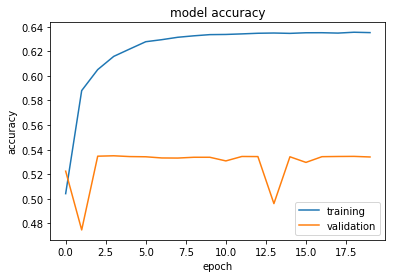

In [95]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

## Model Comparison ##

In [96]:
df_results = pd.DataFrame({'classifier':['LR','LR','LR','MLP','MLP','MLP','DT','DT','DT','RF','RF','RF','NN','NN','NN'],
                           'data_set':['train','valid','Test']*5,
                          'accuracy':[0.6462368054698927, 0.520676390447187,0.5277481323372465,
                                      0.6356283151532239,0.5350216380830262,0.5382070437566703,
                                      0.6441221562373342, 0.5064914249078378,0.5082177161152615,
                                      0.6356283151532239,0.5350216380830262,0.5382070437566703,
                                      0.6351701411570377,0.5340599455423014,0.5367129135538954,]})
                          

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

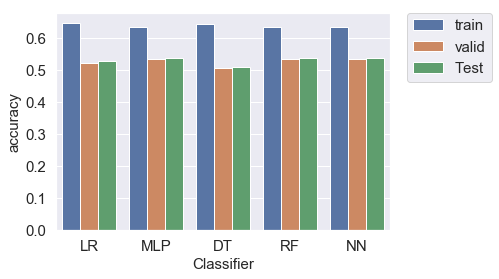

In [98]:
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('accuracy', fontsize = 15)
ax.tick_params(labelsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()